In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"parsamohebian","key":"e43c5c7c7d73b474ba14f8f40c39ad1a"}'}

In [ ]:
import shutil
import os

os.makedirs("/root/.kaggle", exist_ok=True)

shutil.move("kaggle.json", "/root/.kaggle/kaggle.json")

os.chmod("/root/.kaggle/kaggle.json", 600)

In [ ]:
!pip install kaggle  # Ensure Kaggle CLI is installed


In [ ]:
!kaggle datasets download -d subhajeetdas/iq-othnccd-lung-cancer-dataset-augmented


Dataset URL: https://www.kaggle.com/datasets/subhajeetdas/iq-othnccd-lung-cancer-dataset-augmented
License(s): MIT
100% 169M/169M [00:01<00:00, 104MB/s]
100% 169M/169M [00:01<00:00, 98.5MB/s]


In [ ]:
import zipfile

with zipfile.ZipFile("iq-othnccd-lung-cancer-dataset-augmented.zip", "r") as zip_ref:
    zip_ref.extractall("lung_cancer_dataset")

!ls lung_cancer_dataset


'Augmented IQ-OTHNCCD lung cancer dataset'


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Move the extracted dataset to Google Drive
!mv lung_cancer_dataset /content/drive/MyDrive/lung_cancer_dataset


In [ ]:
!ls /content/drive/MyDrive/lung_cancer_dataset/Augmented\ IQ-OTHNCCD\ lung\ cancer\ dataset


'Augmentation Details.txt'  'Benign cases'  'Malignant cases'  'Normal cases'


In [ ]:
import os
benign_count = len(os.listdir("/content/drive/MyDrive/lung_cancer_dataset/Augmented IQ-OTHNCCD lung cancer dataset/Benign cases"))
print(f"Benign cases: {benign_count} files")

malignant_count = len(os.listdir("/content/drive/MyDrive/lung_cancer_dataset/Augmented IQ-OTHNCCD lung cancer dataset/Malignant cases"))
print(f"Malignant cases: {malignant_count} files")

normal_count = len(os.listdir("/content/drive/MyDrive/lung_cancer_dataset/Augmented IQ-OTHNCCD lung cancer dataset/Normal cases"))
print(f"Normal cases: {normal_count} files")


Benign cases: 1200 files
Malignant cases: 1201 files
Normal cases: 1208 files


In [ ]:
import os
import pandas as pd

base_path = "/content/drive/MyDrive/lung_cancer_dataset/Augmented IQ-OTHNCCD lung cancer dataset"

folders = {
    "Benign cases": "Benign",
    "Malignant cases": "Malignant",
    "Normal cases": "Normal"
}

data = []

for folder, label in folders.items():
    folder_path = os.path.join(base_path, folder)
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        data.append([file_path, label])

df = pd.DataFrame(data, columns=["File_Path", "Label"])

output_csv = "/content/drive/MyDrive/lung_cancer_file_paths.csv"
df.to_csv(output_csv, index=False)

print(f"CSV saved at: {output_csv}")


CSV saved at: /content/drive/MyDrive/lung_cancer_file_paths.csv


In [ ]:
import torch
from torchvision.models import resnet50, ResNet50_Weights
import numpy as np
import glob
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm_notebook as tqdm

In [ ]:
class LungCancerDataset(torch.utils.data.Dataset):
    def __init__(self,
                 df = None,
                 has_path = True,
                 csv_path = "/content/drive/MyDrive/lung_cancer_file_paths.csv",
                 augment=False):

        if df is None and has_path == True:
            self.df = pd.read_csv(csv_path)
        else:
            self.df = df
        self.augment_ = augment

    def __len__(self):
        return self.df.shape[0]


    def __getitem__(self, idx):
        image_path = self.df.iloc[idx]["File_Path"]
        label = self.df.iloc[idx]["Label"]
        image = cv2.imread(image_path)
        image = cv2.resize(image, (224, 224))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.augment_:
            image = self.augment(image)
        image = self.normalize(image)

        return image.transpose(2, 0, 1).astype(np.float32), label

    def normalize(self, image):
        image = image / 255
        image = image - np.array([0.485, 0.456, 0.406])
        image = image / np.array([0.229, 0.224, 0.225])
        return image


    def augment(self, image):
        image_HSV = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        value_change = np.random.normal(0, 10)
        sat_change = np.random.normal(0, 10)
        image_HSV = image_HSV.astype(np.float32)
        image_HSV[:, :, 1] += sat_change
        image_HSV[:, :, 2] += value_change
        image_HSV = np.clip(image_HSV, 0, 255).astype(np.uint8)
        image = cv2.cvtColor(image_HSV, cv2.COLOR_HSV2RGB)
        return image


In [ ]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

csv_path = "/content/drive/MyDrive/lung_cancer_file_paths.csv"
df = pd.read_csv(csv_path)

le = LabelEncoder()

df['label_encoded'] = le.fit_transform(df['Label'])

df = df.drop(columns=['Label'])

df = df.rename(columns={'label_encoded': 'Label'})


In [ ]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Label'])


In [ ]:
train_dataset = LungCancerDataset(df=train_df, has_path=False, augment=True)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, num_workers=2)

val_dataset = LungCancerDataset(df=val_df, has_path=False, augment=False)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, num_workers=2, shuffle=False)

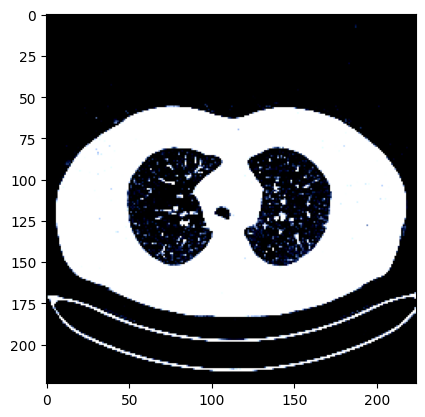

In [ ]:
plt.imshow(train_dataset[6][0].transpose([1,2,0]))

In [ ]:
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2).cuda()

model

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 189MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
model.fc = torch.nn.Identity()
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Sequential(
    torch.nn.Linear(2048, 3)
)

for param in model.parameters():
    print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True


In [ ]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
model = model.cuda()


In [ ]:
for epoch in range(5):
    model.train()

    pbar = tqdm(train_dataloader, desc=f"Traininig Epoch {epoch}")
    for x, y in pbar:
        x = x.float().cuda()
        y = y.cuda()
        optimizer.zero_grad()

        output = model(x)

        loss = loss_function(output, y)
        pbar.set_postfix_str(f"Loss: {loss.item():.4f}")

        loss.backward()
        optimizer.step()

    model.eval()
    pbar = tqdm(val_dataloader, desc=f"Testing Epoch {epoch}")
    sum_loss = 0
    sum_correct = 0
    sum_samples = 0
    for x, y in pbar:
        x = x.float().cuda()
        y = y.cuda()

        with torch.no_grad():
            output = model(x)
            loss = loss_function(output, y)

            sum_loss += loss.item() * len(y)
            sum_samples += len(y)
            sum_correct += ((output.argmax(axis=1)) == y).sum().item()

    print(f"Average test loss: {sum_loss / sum_samples}")
    print(f"Average test Accuracy: {sum_correct / sum_samples}")
    print("--------------------------------")

<ipython-input-13-502b23976f47>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm(train_dataloader, desc=f"Traininig Epoch {epoch}")


Traininig Epoch 0:   0%|          | 0/91 [00:00<?, ?it/s]

<ipython-input-13-502b23976f47>:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm(val_dataloader, desc=f"Testing Epoch {epoch}")


Testing Epoch 0:   0%|          | 0/23 [00:00<?, ?it/s]

Average test loss: 1.1004644232773715
Average test Accuracy: 0.34210526315789475
--------------------------------


Traininig Epoch 1:   0%|          | 0/91 [00:00<?, ?it/s]

Testing Epoch 1:   0%|          | 0/23 [00:00<?, ?it/s]

Average test loss: 1.0882634300934642
Average test Accuracy: 0.40581717451523547
--------------------------------


Traininig Epoch 2:   0%|          | 0/91 [00:00<?, ?it/s]

Testing Epoch 2:   0%|          | 0/23 [00:00<?, ?it/s]

Average test loss: 1.0772977426771972
Average test Accuracy: 0.4667590027700831
--------------------------------


Traininig Epoch 3:   0%|          | 0/91 [00:00<?, ?it/s]

Testing Epoch 3:   0%|          | 0/23 [00:00<?, ?it/s]

Average test loss: 1.067161779324434
Average test Accuracy: 0.5193905817174516
--------------------------------


Traininig Epoch 4:   0%|          | 0/91 [00:00<?, ?it/s]

Testing Epoch 4:   0%|          | 0/23 [00:00<?, ?it/s]

Average test loss: 1.0560108248216624
Average test Accuracy: 0.5678670360110804
--------------------------------


In [ ]:
for epoch in range(2):
    model.train()

    pbar = tqdm(train_dataloader, desc=f"Traininig Epoch {epoch}")
    for x, y in pbar:
        x = x.float().cuda()
        y = y.cuda()
        optimizer.zero_grad()

        output = model(x)

        loss = loss_function(output, y)
        pbar.set_postfix_str(f"Loss: {loss.item():.4f}")

        loss.backward()
        optimizer.step()

    model.eval()
    pbar = tqdm(val_dataloader, desc=f"Testing Epoch {epoch}")
    sum_loss = 0
    sum_correct = 0
    sum_samples = 0
    for x, y in pbar:
        x = x.float().cuda()
        y = y.cuda()

        with torch.no_grad():
            output = model(x)
            loss = loss_function(output, y)

            sum_loss += loss.item() * len(y)
            sum_samples += len(y)
            sum_correct += ((output.argmax(axis=1)) == y).sum().item()

    print(f"Average test loss: {sum_loss / sum_samples}")
    print(f"Average test Accuracy: {sum_correct / sum_samples}")
    print("--------------------------------")

<ipython-input-14-bc6184f23d16>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm(train_dataloader, desc=f"Traininig Epoch {epoch}")


Traininig Epoch 0:   0%|          | 0/91 [00:00<?, ?it/s]

<ipython-input-14-bc6184f23d16>:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm(val_dataloader, desc=f"Testing Epoch {epoch}")


Testing Epoch 0:   0%|          | 0/23 [00:00<?, ?it/s]

Average test loss: 1.0473384880293108
Average test Accuracy: 0.610803324099723
--------------------------------


Traininig Epoch 1:   0%|          | 0/91 [00:00<?, ?it/s]

Testing Epoch 1:   0%|          | 0/23 [00:00<?, ?it/s]

Average test loss: 1.0360750121753302
Average test Accuracy: 0.6426592797783933
--------------------------------


In [ ]:
for epoch in range(1):
    model.train()

    pbar = tqdm(train_dataloader, desc=f"Traininig Epoch {epoch}")
    for x, y in pbar:
        x = x.float().cuda()
        y = y.cuda()
        optimizer.zero_grad()

        output = model(x)

        loss = loss_function(output, y)
        pbar.set_postfix_str(f"Loss: {loss.item():.4f}")

        loss.backward()
        optimizer.step()

    model.eval()
    pbar = tqdm(val_dataloader, desc=f"Testing Epoch {epoch}")
    sum_loss = 0
    sum_correct = 0
    sum_samples = 0
    for x, y in pbar:
        x = x.float().cuda()
        y = y.cuda()

        with torch.no_grad():
            output = model(x)
            loss = loss_function(output, y)

            sum_loss += loss.item() * len(y)
            sum_samples += len(y)
            sum_correct += ((output.argmax(axis=1)) == y).sum().item()

    print(f"Average test loss: {sum_loss / sum_samples}")
    print(f"Average test Accuracy: {sum_correct / sum_samples}")
    print("--------------------------------")

<ipython-input-15-649cf4556b7a>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm(train_dataloader, desc=f"Traininig Epoch {epoch}")


Traininig Epoch 0:   0%|          | 0/91 [00:00<?, ?it/s]

<ipython-input-15-649cf4556b7a>:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm(val_dataloader, desc=f"Testing Epoch {epoch}")


Testing Epoch 0:   0%|          | 0/23 [00:00<?, ?it/s]

Average test loss: 1.02755245211382
Average test Accuracy: 0.6523545706371191
--------------------------------


In [ ]:
for layer in model.parameters():
    layer.requires_grad = True

In [ ]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

model = model.cuda()

In [ ]:
for epoch in range(1):
    model.train()

    pbar = tqdm(train_dataloader, desc=f"Traininig Epoch {epoch}")
    for x, y in pbar:
        x = x.float().cuda()
        y = y.cuda()
        optimizer.zero_grad()

        output = model(x)

        loss = loss_function(output, y)
        pbar.set_postfix_str(f"Loss: {loss.item():.4f}")

        loss.backward()
        optimizer.step()

    model.eval()
    pbar = tqdm(val_dataloader, desc=f"Testing Epoch {epoch}")
    sum_loss = 0
    sum_correct = 0
    sum_samples = 0
    for x, y in pbar:
        x = x.float().cuda()
        y = y.cuda()

        with torch.no_grad():
            output = model(x)
            loss = loss_function(output, y)

            sum_loss += loss.item() * len(y)
            sum_samples += len(y)
            sum_correct += ((output.argmax(axis=1)) == y).sum().item()

    print(f"Average test loss: {sum_loss / sum_samples}")
    print(f"Average test Accuracy: {sum_correct / sum_samples}")
    print("--------------------------------")

<ipython-input-19-649cf4556b7a>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm(train_dataloader, desc=f"Traininig Epoch {epoch}")


Traininig Epoch 0:   0%|          | 0/91 [00:00<?, ?it/s]

<ipython-input-19-649cf4556b7a>:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm(val_dataloader, desc=f"Testing Epoch {epoch}")


Testing Epoch 0:   0%|          | 0/23 [00:00<?, ?it/s]

Average test loss: 0.5243448051224124
Average test Accuracy: 0.8033240997229917
--------------------------------


In [ ]:
for epoch in range(1):
    model.train()

    pbar = tqdm(train_dataloader, desc=f"Traininig Epoch {epoch}")
    for x, y in pbar:
        x = x.float().cuda()
        y = y.cuda()
        optimizer.zero_grad()

        output = model(x)

        loss = loss_function(output, y)
        pbar.set_postfix_str(f"Loss: {loss.item():.4f}")

        loss.backward()
        optimizer.step()

    model.eval()
    pbar = tqdm(val_dataloader, desc=f"Testing Epoch {epoch}")
    sum_loss = 0
    sum_correct = 0
    sum_samples = 0
    for x, y in pbar:
        x = x.float().cuda()
        y = y.cuda()

        with torch.no_grad():
            output = model(x)
            loss = loss_function(output, y)

            sum_loss += loss.item() * len(y)
            sum_samples += len(y)
            sum_correct += ((output.argmax(axis=1)) == y).sum().item()

    print(f"Average test loss: {sum_loss / sum_samples}")
    print(f"Average test Accuracy: {sum_correct / sum_samples}")
    print("--------------------------------")

<ipython-input-20-649cf4556b7a>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm(train_dataloader, desc=f"Traininig Epoch {epoch}")


Traininig Epoch 0:   0%|          | 0/91 [00:00<?, ?it/s]

<ipython-input-20-649cf4556b7a>:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm(val_dataloader, desc=f"Testing Epoch {epoch}")


Testing Epoch 0:   0%|          | 0/23 [00:00<?, ?it/s]

Average test loss: 0.39643425731777815
Average test Accuracy: 0.8490304709141274
--------------------------------


In [ ]:
for epoch in range(1):
    model.train()

    pbar = tqdm(train_dataloader, desc=f"Traininig Epoch {epoch}")
    for x, y in pbar:
        x = x.float().cuda()
        y = y.cuda()
        optimizer.zero_grad()

        output = model(x)

        loss = loss_function(output, y)
        pbar.set_postfix_str(f"Loss: {loss.item():.4f}")

        loss.backward()
        optimizer.step()

    model.eval()
    pbar = tqdm(val_dataloader, desc=f"Testing Epoch {epoch}")
    sum_loss = 0
    sum_correct = 0
    sum_samples = 0
    for x, y in pbar:
        x = x.float().cuda()
        y = y.cuda()

        with torch.no_grad():
            output = model(x)
            loss = loss_function(output, y)

            sum_loss += loss.item() * len(y)
            sum_samples += len(y)
            sum_correct += ((output.argmax(axis=1)) == y).sum().item()

    print(f"Average test loss: {sum_loss / sum_samples}")
    print(f"Average test Accuracy: {sum_correct / sum_samples}")
    print("--------------------------------")

<ipython-input-21-649cf4556b7a>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm(train_dataloader, desc=f"Traininig Epoch {epoch}")


Traininig Epoch 0:   0%|          | 0/91 [00:00<?, ?it/s]

<ipython-input-21-649cf4556b7a>:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm(val_dataloader, desc=f"Testing Epoch {epoch}")


Testing Epoch 0:   0%|          | 0/23 [00:00<?, ?it/s]

Average test loss: 0.3069971214948929
Average test Accuracy: 0.8864265927977839
--------------------------------


In [ ]:
for epoch in range(1):
    model.train()

    pbar = tqdm(train_dataloader, desc=f"Traininig Epoch {epoch}")
    for x, y in pbar:
        x = x.float().cuda()
        y = y.cuda()
        optimizer.zero_grad()

        output = model(x)

        loss = loss_function(output, y)
        pbar.set_postfix_str(f"Loss: {loss.item():.4f}")

        loss.backward()
        optimizer.step()

    model.eval()
    pbar = tqdm(val_dataloader, desc=f"Testing Epoch {epoch}")
    sum_loss = 0
    sum_correct = 0
    sum_samples = 0
    for x, y in pbar:
        x = x.float().cuda()
        y = y.cuda()

        with torch.no_grad():
            output = model(x)
            loss = loss_function(output, y)

            sum_loss += loss.item() * len(y)
            sum_samples += len(y)
            sum_correct += ((output.argmax(axis=1)) == y).sum().item()

    print(f"Average test loss: {sum_loss / sum_samples}")
    print(f"Average test Accuracy: {sum_correct / sum_samples}")
    print("--------------------------------")

<ipython-input-22-649cf4556b7a>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm(train_dataloader, desc=f"Traininig Epoch {epoch}")


Traininig Epoch 0:   0%|          | 0/91 [00:00<?, ?it/s]

<ipython-input-22-649cf4556b7a>:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm(val_dataloader, desc=f"Testing Epoch {epoch}")


Testing Epoch 0:   0%|          | 0/23 [00:00<?, ?it/s]

Average test loss: 0.2192618058287536
Average test Accuracy: 0.9349030470914127
--------------------------------


In [ ]:
for epoch in range(1):
    model.train()

    pbar = tqdm(train_dataloader, desc=f"Traininig Epoch {epoch}")
    for x, y in pbar:
        x = x.float().cuda()
        y = y.cuda()
        optimizer.zero_grad()

        output = model(x)

        loss = loss_function(output, y)
        pbar.set_postfix_str(f"Loss: {loss.item():.4f}")

        loss.backward()
        optimizer.step()

    model.eval()
    pbar = tqdm(val_dataloader, desc=f"Testing Epoch {epoch}")
    sum_loss = 0
    sum_correct = 0
    sum_samples = 0
    for x, y in pbar:
        x = x.float().cuda()
        y = y.cuda()

        with torch.no_grad():
            output = model(x)
            loss = loss_function(output, y)

            sum_loss += loss.item() * len(y)
            sum_samples += len(y)
            sum_correct += ((output.argmax(axis=1)) == y).sum().item()

    print(f"Average test loss: {sum_loss / sum_samples}")
    print(f"Average test Accuracy: {sum_correct / sum_samples}")
    print("--------------------------------")

<ipython-input-23-649cf4556b7a>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm(train_dataloader, desc=f"Traininig Epoch {epoch}")


Traininig Epoch 0:   0%|          | 0/91 [00:00<?, ?it/s]

<ipython-input-23-649cf4556b7a>:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm(val_dataloader, desc=f"Testing Epoch {epoch}")


Testing Epoch 0:   0%|          | 0/23 [00:00<?, ?it/s]

Average test loss: 0.17317920434095194
Average test Accuracy: 0.9501385041551247
--------------------------------


In [ ]:
for epoch in range(1):
    model.train()

    pbar = tqdm(train_dataloader, desc=f"Traininig Epoch {epoch}")
    for x, y in pbar:
        x = x.float().cuda()
        y = y.cuda()
        optimizer.zero_grad()

        output = model(x)

        loss = loss_function(output, y)
        pbar.set_postfix_str(f"Loss: {loss.item():.4f}")

        loss.backward()
        optimizer.step()

    model.eval()
    pbar = tqdm(val_dataloader, desc=f"Testing Epoch {epoch}")
    sum_loss = 0
    sum_correct = 0
    sum_samples = 0
    for x, y in pbar:
        x = x.float().cuda()
        y = y.cuda()

        with torch.no_grad():
            output = model(x)
            loss = loss_function(output, y)

            sum_loss += loss.item() * len(y)
            sum_samples += len(y)
            sum_correct += ((output.argmax(axis=1)) == y).sum().item()

    print(f"Average test loss: {sum_loss / sum_samples}")
    print(f"Average test Accuracy: {sum_correct / sum_samples}")
    print("--------------------------------")

<ipython-input-24-649cf4556b7a>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm(train_dataloader, desc=f"Traininig Epoch {epoch}")


Traininig Epoch 0:   0%|          | 0/91 [00:00<?, ?it/s]

<ipython-input-24-649cf4556b7a>:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm(val_dataloader, desc=f"Testing Epoch {epoch}")


Testing Epoch 0:   0%|          | 0/23 [00:00<?, ?it/s]

Average test loss: 0.14079765393463198
Average test Accuracy: 0.9542936288088643
--------------------------------


In [ ]:
for epoch in range(1):
    model.train()

    pbar = tqdm(train_dataloader, desc=f"Traininig Epoch {epoch}")
    for x, y in pbar:
        x = x.float().cuda()
        y = y.cuda()
        optimizer.zero_grad()

        output = model(x)

        loss = loss_function(output, y)
        pbar.set_postfix_str(f"Loss: {loss.item():.4f}")

        loss.backward()
        optimizer.step()

    model.eval()
    pbar = tqdm(val_dataloader, desc=f"Testing Epoch {epoch}")
    sum_loss = 0
    sum_correct = 0
    sum_samples = 0
    for x, y in pbar:
        x = x.float().cuda()
        y = y.cuda()

        with torch.no_grad():
            output = model(x)
            loss = loss_function(output, y)

            sum_loss += loss.item() * len(y)
            sum_samples += len(y)
            sum_correct += ((output.argmax(axis=1)) == y).sum().item()

    print(f"Average test loss: {sum_loss / sum_samples}")
    print(f"Average test Accuracy: {sum_correct / sum_samples}")
    print("--------------------------------")

<ipython-input-25-649cf4556b7a>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm(train_dataloader, desc=f"Traininig Epoch {epoch}")


Traininig Epoch 0:   0%|          | 0/91 [00:00<?, ?it/s]

<ipython-input-25-649cf4556b7a>:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm(val_dataloader, desc=f"Testing Epoch {epoch}")


Testing Epoch 0:   0%|          | 0/23 [00:00<?, ?it/s]

Average test loss: 0.13787182251254607
Average test Accuracy: 0.9556786703601108
--------------------------------


In [ ]:
import torch

# Save the model's state dictionary
model_path = "/content/drive/MyDrive/resnet50_lung_cancer_1.pth"
torch.save(model.state_dict(), model_path)

print(f"Model saved at: {model_path}")


Model saved at: /content/drive/MyDrive/resnet50_lung_cancer_1.pth


In [ ]:
train_dataset = LungCancerDataset(df=train_df, has_path=False, augment=False)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, num_workers=2)

val_dataset = LungCancerDataset(df=val_df, has_path=False, augment=False)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, num_workers=2, shuffle=False)

In [ ]:
model2 = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2).cuda()

model2

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 130MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
model2.fc = torch.nn.Identity()
for param in model2.parameters():
    param.requires_grad = False

model2.fc = torch.nn.Sequential(
    torch.nn.Linear(2048, 3)
)

for param in model2.parameters():
    print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True


In [ ]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=1e-5)
model2 = model2.cuda()


In [ ]:
for epoch in range(5):
    model2.train()

    pbar = tqdm(train_dataloader, desc=f"Traininig Epoch {epoch}")
    for x, y in pbar:
        x = x.float().cuda()
        y = y.cuda()
        optimizer.zero_grad()

        output = model2(x)

        loss = loss_function(output, y)
        pbar.set_postfix_str(f"Loss: {loss.item():.4f}")

        loss.backward()
        optimizer.step()

    model2.eval()
    pbar = tqdm(val_dataloader, desc=f"Testing Epoch {epoch}")
    sum_loss = 0
    sum_correct = 0
    sum_samples = 0
    for x, y in pbar:
        x = x.float().cuda()
        y = y.cuda()

        with torch.no_grad():
            output = model2(x)
            loss = loss_function(output, y)

            sum_loss += loss.item() * len(y)
            sum_samples += len(y)
            sum_correct += ((output.argmax(axis=1)) == y).sum().item()

    print(f"Average test loss: {sum_loss / sum_samples}")
    print(f"Average test Accuracy: {sum_correct / sum_samples}")
    print("--------------------------------")

<ipython-input-15-28c4e7807a05>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm(train_dataloader, desc=f"Traininig Epoch {epoch}")


Traininig Epoch 0:   0%|          | 0/91 [00:00<?, ?it/s]

<ipython-input-15-28c4e7807a05>:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm(val_dataloader, desc=f"Testing Epoch {epoch}")


Testing Epoch 0:   0%|          | 0/23 [00:00<?, ?it/s]

Average test loss: 1.0972243246939704
Average test Accuracy: 0.33518005540166207
--------------------------------


Traininig Epoch 1:   0%|          | 0/91 [00:00<?, ?it/s]

Testing Epoch 1:   0%|          | 0/23 [00:00<?, ?it/s]

Average test loss: 1.0828482807508135
Average test Accuracy: 0.4002770083102493
--------------------------------


Traininig Epoch 2:   0%|          | 0/91 [00:00<?, ?it/s]

Testing Epoch 2:   0%|          | 0/23 [00:00<?, ?it/s]

Average test loss: 1.0696273371783651
Average test Accuracy: 0.4695290858725762
--------------------------------


Traininig Epoch 3:   0%|          | 0/91 [00:00<?, ?it/s]

Testing Epoch 3:   0%|          | 0/23 [00:00<?, ?it/s]

Average test loss: 1.0568958032164217
Average test Accuracy: 0.5318559556786704
--------------------------------


Traininig Epoch 4:   0%|          | 0/91 [00:00<?, ?it/s]

Testing Epoch 4:   0%|          | 0/23 [00:00<?, ?it/s]

Average test loss: 1.0446007311179037
Average test Accuracy: 0.5872576177285319
--------------------------------


In [ ]:
for epoch in range(3):
    model2.train()

    pbar = tqdm(train_dataloader, desc=f"Traininig Epoch {epoch}")
    for x, y in pbar:
        x = x.float().cuda()
        y = y.cuda()
        optimizer.zero_grad()

        output = model2(x)

        loss = loss_function(output, y)
        pbar.set_postfix_str(f"Loss: {loss.item():.4f}")

        loss.backward()
        optimizer.step()

    model2.eval()
    pbar = tqdm(val_dataloader, desc=f"Testing Epoch {epoch}")
    sum_loss = 0
    sum_correct = 0
    sum_samples = 0
    for x, y in pbar:
        x = x.float().cuda()
        y = y.cuda()

        with torch.no_grad():
            output = model2(x)
            loss = loss_function(output, y)

            sum_loss += loss.item() * len(y)
            sum_samples += len(y)
            sum_correct += ((output.argmax(axis=1)) == y).sum().item()

    print(f"Average test loss: {sum_loss / sum_samples}")
    print(f"Average test Accuracy: {sum_correct / sum_samples}")
    print("--------------------------------")

<ipython-input-16-40a385a18e87>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm(train_dataloader, desc=f"Traininig Epoch {epoch}")


Traininig Epoch 0:   0%|          | 0/91 [00:00<?, ?it/s]

<ipython-input-16-40a385a18e87>:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm(val_dataloader, desc=f"Testing Epoch {epoch}")


Testing Epoch 0:   0%|          | 0/23 [00:00<?, ?it/s]

Average test loss: 1.0327112162872696
Average test Accuracy: 0.6218836565096952
--------------------------------


Traininig Epoch 1:   0%|          | 0/91 [00:00<?, ?it/s]

Testing Epoch 1:   0%|          | 0/23 [00:00<?, ?it/s]

Average test loss: 1.0212064413482793
Average test Accuracy: 0.6329639889196675
--------------------------------


Traininig Epoch 2:   0%|          | 0/91 [00:00<?, ?it/s]

Testing Epoch 2:   0%|          | 0/23 [00:00<?, ?it/s]

Average test loss: 1.0100697998855253
Average test Accuracy: 0.646814404432133
--------------------------------


In [ ]:
for epoch in range(2):
    model2.train()

    pbar = tqdm(train_dataloader, desc=f"Traininig Epoch {epoch}")
    for x, y in pbar:
        x = x.float().cuda()
        y = y.cuda()
        optimizer.zero_grad()

        output = model2(x)

        loss = loss_function(output, y)
        pbar.set_postfix_str(f"Loss: {loss.item():.4f}")

        loss.backward()
        optimizer.step()

    model2.eval()
    pbar = tqdm(val_dataloader, desc=f"Testing Epoch {epoch}")
    sum_loss = 0
    sum_correct = 0
    sum_samples = 0
    for x, y in pbar:
        x = x.float().cuda()
        y = y.cuda()

        with torch.no_grad():
            output = model2(x)
            loss = loss_function(output, y)

            sum_loss += loss.item() * len(y)
            sum_samples += len(y)
            sum_correct += ((output.argmax(axis=1)) == y).sum().item()

    print(f"Average test loss: {sum_loss / sum_samples}")
    print(f"Average test Accuracy: {sum_correct / sum_samples}")
    print("--------------------------------")

<ipython-input-17-42a18ffe182a>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm(train_dataloader, desc=f"Traininig Epoch {epoch}")


Traininig Epoch 0:   0%|          | 0/91 [00:00<?, ?it/s]

<ipython-input-17-42a18ffe182a>:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm(val_dataloader, desc=f"Testing Epoch {epoch}")


Testing Epoch 0:   0%|          | 0/23 [00:00<?, ?it/s]

Average test loss: 0.999286865593654
Average test Accuracy: 0.6606648199445984
--------------------------------


Traininig Epoch 1:   0%|          | 0/91 [00:00<?, ?it/s]

Testing Epoch 1:   0%|          | 0/23 [00:00<?, ?it/s]

Average test loss: 0.9888440740405687
Average test Accuracy: 0.6717451523545707
--------------------------------


In [ ]:
for epoch in range(1):
    model2.train()

    pbar = tqdm(train_dataloader, desc=f"Traininig Epoch {epoch}")
    for x, y in pbar:
        x = x.float().cuda()
        y = y.cuda()
        optimizer.zero_grad()

        output = model2(x)

        loss = loss_function(output, y)
        pbar.set_postfix_str(f"Loss: {loss.item():.4f}")

        loss.backward()
        optimizer.step()

    model2.eval()
    pbar = tqdm(val_dataloader, desc=f"Testing Epoch {epoch}")
    sum_loss = 0
    sum_correct = 0
    sum_samples = 0
    for x, y in pbar:
        x = x.float().cuda()
        y = y.cuda()

        with torch.no_grad():
            output = model2(x)
            loss = loss_function(output, y)

            sum_loss += loss.item() * len(y)
            sum_samples += len(y)
            sum_correct += ((output.argmax(axis=1)) == y).sum().item()

    print(f"Average test loss: {sum_loss / sum_samples}")
    print(f"Average test Accuracy: {sum_correct / sum_samples}")
    print("--------------------------------")

<ipython-input-18-eb83a8a80d45>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm(train_dataloader, desc=f"Traininig Epoch {epoch}")


Traininig Epoch 0:   0%|          | 0/91 [00:00<?, ?it/s]

<ipython-input-18-eb83a8a80d45>:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm(val_dataloader, desc=f"Testing Epoch {epoch}")


Testing Epoch 0:   0%|          | 0/23 [00:00<?, ?it/s]

Average test loss: 0.9787286014768225
Average test Accuracy: 0.6869806094182825
--------------------------------


In [ ]:
for epoch in range(1):
    model2.train()

    pbar = tqdm(train_dataloader, desc=f"Traininig Epoch {epoch}")
    for x, y in pbar:
        x = x.float().cuda()
        y = y.cuda()
        optimizer.zero_grad()

        output = model2(x)

        loss = loss_function(output, y)
        pbar.set_postfix_str(f"Loss: {loss.item():.4f}")

        loss.backward()
        optimizer.step()

    model2.eval()
    pbar = tqdm(val_dataloader, desc=f"Testing Epoch {epoch}")
    sum_loss = 0
    sum_correct = 0
    sum_samples = 0
    for x, y in pbar:
        x = x.float().cuda()
        y = y.cuda()

        with torch.no_grad():
            output = model2(x)
            loss = loss_function(output, y)

            sum_loss += loss.item() * len(y)
            sum_samples += len(y)
            sum_correct += ((output.argmax(axis=1)) == y).sum().item()

    print(f"Average test loss: {sum_loss / sum_samples}")
    print(f"Average test Accuracy: {sum_correct / sum_samples}")
    print("--------------------------------")

<ipython-input-19-eb83a8a80d45>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm(train_dataloader, desc=f"Traininig Epoch {epoch}")


Traininig Epoch 0:   0%|          | 0/91 [00:00<?, ?it/s]

<ipython-input-19-eb83a8a80d45>:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm(val_dataloader, desc=f"Testing Epoch {epoch}")


Testing Epoch 0:   0%|          | 0/23 [00:00<?, ?it/s]

Average test loss: 0.96892791491136
Average test Accuracy: 0.6925207756232687
--------------------------------


In [ ]:
for epoch in range(3):
    model2.train()

    pbar = tqdm(train_dataloader, desc=f"Traininig Epoch {epoch}")
    for x, y in pbar:
        x = x.float().cuda()
        y = y.cuda()
        optimizer.zero_grad()

        output = model2(x)

        loss = loss_function(output, y)
        pbar.set_postfix_str(f"Loss: {loss.item():.4f}")

        loss.backward()
        optimizer.step()

    model2.eval()
    pbar = tqdm(val_dataloader, desc=f"Testing Epoch {epoch}")
    sum_loss = 0
    sum_correct = 0
    sum_samples = 0
    for x, y in pbar:
        x = x.float().cuda()
        y = y.cuda()

        with torch.no_grad():
            output = model2(x)
            loss = loss_function(output, y)

            sum_loss += loss.item() * len(y)
            sum_samples += len(y)
            sum_correct += ((output.argmax(axis=1)) == y).sum().item()

    print(f"Average test loss: {sum_loss / sum_samples}")
    print(f"Average test Accuracy: {sum_correct / sum_samples}")
    print("--------------------------------")

<ipython-input-20-40a385a18e87>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm(train_dataloader, desc=f"Traininig Epoch {epoch}")


Traininig Epoch 0:   0%|          | 0/91 [00:00<?, ?it/s]

<ipython-input-20-40a385a18e87>:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm(val_dataloader, desc=f"Testing Epoch {epoch}")


Testing Epoch 0:   0%|          | 0/23 [00:00<?, ?it/s]

Average test loss: 0.9594300285270669
Average test Accuracy: 0.7022160664819944
--------------------------------


Traininig Epoch 1:   0%|          | 0/91 [00:00<?, ?it/s]

Testing Epoch 1:   0%|          | 0/23 [00:00<?, ?it/s]

Average test loss: 0.950223256676481
Average test Accuracy: 0.7119113573407202
--------------------------------


Traininig Epoch 2:   0%|          | 0/91 [00:00<?, ?it/s]

Testing Epoch 2:   0%|          | 0/23 [00:00<?, ?it/s]

Average test loss: 0.9412963535646983
Average test Accuracy: 0.7160664819944599
--------------------------------


In [ ]:
for epoch in range(2):
    model2.train()

    pbar = tqdm(train_dataloader, desc=f"Traininig Epoch {epoch}")
    for x, y in pbar:
        x = x.float().cuda()
        y = y.cuda()
        optimizer.zero_grad()

        output = model2(x)

        loss = loss_function(output, y)
        pbar.set_postfix_str(f"Loss: {loss.item():.4f}")

        loss.backward()
        optimizer.step()

    model2.eval()
    pbar = tqdm(val_dataloader, desc=f"Testing Epoch {epoch}")
    sum_loss = 0
    sum_correct = 0
    sum_samples = 0
    for x, y in pbar:
        x = x.float().cuda()
        y = y.cuda()

        with torch.no_grad():
            output = model2(x)
            loss = loss_function(output, y)

            sum_loss += loss.item() * len(y)
            sum_samples += len(y)
            sum_correct += ((output.argmax(axis=1)) == y).sum().item()

    print(f"Average test loss: {sum_loss / sum_samples}")
    print(f"Average test Accuracy: {sum_correct / sum_samples}")
    print("--------------------------------")

<ipython-input-21-42a18ffe182a>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm(train_dataloader, desc=f"Traininig Epoch {epoch}")


Traininig Epoch 0:   0%|          | 0/91 [00:00<?, ?it/s]

<ipython-input-21-42a18ffe182a>:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm(val_dataloader, desc=f"Testing Epoch {epoch}")


Testing Epoch 0:   0%|          | 0/23 [00:00<?, ?it/s]

Average test loss: 0.9326384516634109
Average test Accuracy: 0.7146814404432132
--------------------------------


Traininig Epoch 1:   0%|          | 0/91 [00:00<?, ?it/s]

Testing Epoch 1:   0%|          | 0/23 [00:00<?, ?it/s]

Average test loss: 0.9242390217543309
Average test Accuracy: 0.7188365650969529
--------------------------------


In [ ]:
for layer in model2.parameters():
    layer.requires_grad = True

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=1e-5)

model2 = model2.cuda()

In [ ]:
for epoch in range(5):
    model2.train()

    pbar = tqdm(train_dataloader, desc=f"Traininig Epoch {epoch}")
    for x, y in pbar:
        x = x.float().cuda()
        y = y.cuda()
        optimizer.zero_grad()

        output = model2(x)

        loss = loss_function(output, y)
        pbar.set_postfix_str(f"Loss: {loss.item():.4f}")

        loss.backward()
        optimizer.step()

    model2.eval()
    pbar = tqdm(val_dataloader, desc=f"Testing Epoch {epoch}")
    sum_loss = 0
    sum_correct = 0
    sum_samples = 0
    for x, y in pbar:
        x = x.float().cuda()
        y = y.cuda()

        with torch.no_grad():
            output = model2(x)
            loss = loss_function(output, y)

            sum_loss += loss.item() * len(y)
            sum_samples += len(y)
            sum_correct += ((output.argmax(axis=1)) == y).sum().item()

    print(f"Average test loss: {sum_loss / sum_samples}")
    print(f"Average test Accuracy: {sum_correct / sum_samples}")
    print("--------------------------------")

<ipython-input-25-28c4e7807a05>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm(train_dataloader, desc=f"Traininig Epoch {epoch}")


Traininig Epoch 0:   0%|          | 0/91 [00:00<?, ?it/s]

<ipython-input-25-28c4e7807a05>:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm(val_dataloader, desc=f"Testing Epoch {epoch}")


Testing Epoch 0:   0%|          | 0/23 [00:00<?, ?it/s]

Average test loss: 0.5995671970362149
Average test Accuracy: 0.7908587257617729
--------------------------------


Traininig Epoch 1:   0%|          | 0/91 [00:00<?, ?it/s]

Testing Epoch 1:   0%|          | 0/23 [00:00<?, ?it/s]

Average test loss: 0.45697724290831926
Average test Accuracy: 0.8268698060941828
--------------------------------


Traininig Epoch 2:   0%|          | 0/91 [00:00<?, ?it/s]

Testing Epoch 2:   0%|          | 0/23 [00:00<?, ?it/s]

Average test loss: 0.35493892575730246
Average test Accuracy: 0.8698060941828255
--------------------------------


Traininig Epoch 3:   0%|          | 0/91 [00:00<?, ?it/s]

Testing Epoch 3:   0%|          | 0/23 [00:00<?, ?it/s]

Average test loss: 0.2750074177815313
Average test Accuracy: 0.9058171745152355
--------------------------------


Traininig Epoch 4:   0%|          | 0/91 [00:00<?, ?it/s]

Testing Epoch 4:   0%|          | 0/23 [00:00<?, ?it/s]

Average test loss: 0.21806359119775223
Average test Accuracy: 0.9182825484764543
--------------------------------


In [ ]:
for epoch in range(3):
    model2.train()

    pbar = tqdm(train_dataloader, desc=f"Traininig Epoch {epoch}")
    for x, y in pbar:
        x = x.float().cuda()
        y = y.cuda()
        optimizer.zero_grad()

        output = model2(x)

        loss = loss_function(output, y)
        pbar.set_postfix_str(f"Loss: {loss.item():.4f}")

        loss.backward()
        optimizer.step()

    model2.eval()
    pbar = tqdm(val_dataloader, desc=f"Testing Epoch {epoch}")
    sum_loss = 0
    sum_correct = 0
    sum_samples = 0
    for x, y in pbar:
        x = x.float().cuda()
        y = y.cuda()

        with torch.no_grad():
            output = model2(x)
            loss = loss_function(output, y)

            sum_loss += loss.item() * len(y)
            sum_samples += len(y)
            sum_correct += ((output.argmax(axis=1)) == y).sum().item()

    print(f"Average test loss: {sum_loss / sum_samples}")
    print(f"Average test Accuracy: {sum_correct / sum_samples}")
    print("--------------------------------")

<ipython-input-26-40a385a18e87>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm(train_dataloader, desc=f"Traininig Epoch {epoch}")


Traininig Epoch 0:   0%|          | 0/91 [00:00<?, ?it/s]

<ipython-input-26-40a385a18e87>:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm(val_dataloader, desc=f"Testing Epoch {epoch}")


Testing Epoch 0:   0%|          | 0/23 [00:00<?, ?it/s]

Average test loss: 0.18891762698538747
Average test Accuracy: 0.9362880886426593
--------------------------------


Traininig Epoch 1:   0%|          | 0/91 [00:00<?, ?it/s]

Testing Epoch 1:   0%|          | 0/23 [00:00<?, ?it/s]

Average test loss: 0.17980732856488624
Average test Accuracy: 0.9390581717451524
--------------------------------


Traininig Epoch 2:   0%|          | 0/91 [00:00<?, ?it/s]

Testing Epoch 2:   0%|          | 0/23 [00:00<?, ?it/s]

Average test loss: 0.17537770177807835
Average test Accuracy: 0.9404432132963989
--------------------------------


In [ ]:
for epoch in range(3):
    model2.train()

    pbar = tqdm(train_dataloader, desc=f"Traininig Epoch {epoch}")
    for x, y in pbar:
        x = x.float().cuda()
        y = y.cuda()
        optimizer.zero_grad()

        output = model2(x)

        loss = loss_function(output, y)
        pbar.set_postfix_str(f"Loss: {loss.item():.4f}")

        loss.backward()
        optimizer.step()

    model2.eval()
    pbar = tqdm(val_dataloader, desc=f"Testing Epoch {epoch}")
    sum_loss = 0
    sum_correct = 0
    sum_samples = 0
    for x, y in pbar:
        x = x.float().cuda()
        y = y.cuda()

        with torch.no_grad():
            output = model2(x)
            loss = loss_function(output, y)

            sum_loss += loss.item() * len(y)
            sum_samples += len(y)
            sum_correct += ((output.argmax(axis=1)) == y).sum().item()

    print(f"Average test loss: {sum_loss / sum_samples}")
    print(f"Average test Accuracy: {sum_correct / sum_samples}")
    print("--------------------------------")

<ipython-input-27-40a385a18e87>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm(train_dataloader, desc=f"Traininig Epoch {epoch}")


Traininig Epoch 0:   0%|          | 0/91 [00:00<?, ?it/s]

<ipython-input-27-40a385a18e87>:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm(val_dataloader, desc=f"Testing Epoch {epoch}")


Testing Epoch 0:   0%|          | 0/23 [00:00<?, ?it/s]

Average test loss: 0.17327150217466408
Average test Accuracy: 0.9418282548476454
--------------------------------


Traininig Epoch 1:   0%|          | 0/91 [00:00<?, ?it/s]

Testing Epoch 1:   0%|          | 0/23 [00:00<?, ?it/s]

Average test loss: 0.17489871738731366
Average test Accuracy: 0.9418282548476454
--------------------------------


Traininig Epoch 2:   0%|          | 0/91 [00:00<?, ?it/s]

Testing Epoch 2:   0%|          | 0/23 [00:00<?, ?it/s]

Average test loss: 0.1789803774949999
Average test Accuracy: 0.9404432132963989
--------------------------------
